In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import plotly.graph_objects as go
import random

np.random.seed(0)
torch.manual_seed(0)

Compare both methods to count number of regions.

In [2]:
# Toy MLP : 2D input
class FeedForwardNN2D(torch.nn.Module):
    def __init__(self):
        super(FeedForwardNN2D, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(5, 10))
        self.layers.append(torch.nn.Linear(10, 3))
        self.layers.append(torch.nn.Linear(3, 2))
        self.layers.append(torch.nn.Linear(2, 10))
        self.init_weights_random()

    def init_weights_random(self):
        for layer in self.layers:
            torch.nn.init.normal_(layer.weight)
            torch.nn.init.normal_(layer.bias)

    def forward(self, x):
        activation = []
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
            activation.append( (x > 0).squeeze().int() )

        x = self.layers[-1](x)
        activation = torch.cat(activation, dim=1)
        return x, activation
    
model = FeedForwardNN2D()

## Old way

In [3]:
def plane_samples(points, domain_bounds=[-2, 2], n_samples=800, return_xy=False, return_grid=False):
    x1 = torch.linspace(domain_bounds[0], domain_bounds[1], n_samples)
    x2 = torch.linspace(domain_bounds[0], domain_bounds[1], n_samples)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing='xy')

    basis = torch.concatenate((points[1] - points[0], points[2] - points[0]), dim=1).T
    plane = grid_x1.reshape((n_samples, n_samples, 1)) * basis[0] + grid_x2.reshape((n_samples, n_samples, 1)) * basis[1]
    plane = plane + points[0].view(-1, 5)
    if return_xy:
        return plane, x1, x2
    elif return_grid:
        return plane, grid_x1, grid_x2
    else:
        return plane

Number of regions: 70


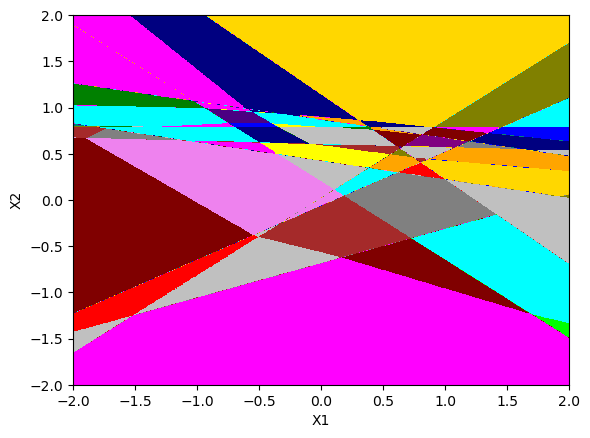

In [4]:
n_samples = 800
points = torch.tensor([[1,1,1,0,0],[1,0,1,0,1],[0,1,0,2,0]], dtype=torch.float32)
points = points[..., None]
torch.concatenate((points[1] - points[0], points[2] - points[0]), dim=1).T
plane, grid_x1, grid_x2 = plane_samples(points, n_samples=n_samples, return_xy=False, return_grid=True)
plane = plane.view(n_samples**2, 5)

with torch.no_grad():
    Y, activations = model(plane)

unique_activations, inverse_indices = torch.unique(activations, dim=0, return_inverse=True)
print(f"Number of regions: {unique_activations.shape[0]}")
#print(unique_activations.numpy().squeeze())
unique_values = torch.unique(inverse_indices).tolist()

# Prepare the plot
color_set = [
        "blue", "green", "yellow", "orange", "red", "purple", "cyan", "magenta",
        "brown", "pink", "lime", "teal", "navy", "gold", "silver", "gray",
        "maroon", "olive", "violet", "indigo"
    ]
color_map = {val: random.choice(color_set) for val in unique_values}

fig = plt.figure()
plt.contourf(
    grid_x1,
    grid_x2,
    inverse_indices.numpy().reshape(n_samples, n_samples),
    colors=[color_map[val] for val in unique_values],
    levels=len(unique_values),
    extend='neither')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## New way

In [5]:
images_plane = np.array([[1,1,1,0,0],[1,0,1,0,1],[0,1,0,2,0]])
images_plane = torch.tensor(images_plane, dtype=torch.float32).view((3,5,1))

In [6]:
def embedding(coordinates, images_plane):
    """
    Embedding of the 2D plane going through images_plane[0], images_plane[1], images_plane[2]
    in input space.
    """
    coordinates = torch.tensor(coordinates, dtype=torch.float32)
    return coordinates[0] * (images_plane[1] - images_plane[0]) + coordinates[1] * (images_plane[2] - images_plane[0]) + images_plane[0]

In [7]:
# Geometric utils
def compute_line_segment_intersection(p1, p2, line_coeffs):
    """
    Segment between two points p1, p2: p1 + t * (p2 - p1) with 0 <= t <= 1.
    Line a * x + b * y + c = 0 with line_coeffs: (a, b, c).
    Output: intersection points if it exists, None otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    
    p1_emb = embedding(p1[..., np.newaxis], images_plane)
    p2_emb = embedding(p2[..., np.newaxis], images_plane)

    w = line_coeffs[0]
    b = line_coeffs[1]

    denominator = w @ (p2_emb - p1_emb)
    if abs(denominator) < 1e-9:  # Parallel line    TODO: Check if the segment is on the line?
        return None

    t = -(b + w @ p1_emb) / denominator
    t = t.item()
    if 0 <= t <= 1:              # Check if intersection is within the segment
        return (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
    return None

def compute_line_region_intersection(convex_hull, line_coeffs):
    """
    convex_hull: scipy.spatial.ConvexHull object.
    line_coeffs: (a, b, c), defining the line a * x + b * y + c = 0.
    Output: list of intersection points.
    """
    intersections = []
    points = convex_hull.points
    for edge in convex_hull.simplices:
        p1, p2 = points[edge[0]], points[edge[1]]
        #p1 = embedding(p1[..., np.newaxis], images)
        #p2 = embedding(p2[..., np.newaxis], images)
        #print(p1.shape)
        point = compute_line_segment_intersection(p1, p2, line_coeffs)
        if point is not None:
            intersections.append(point)
    return intersections

# Definition of main object: the region
class ActivationRegion():
    def __init__(self, vertices, activation_pattern, linear_map):
        self.convex_hull = ConvexHull(vertices)     # TODO: Might be an overkill? Just need the vertices
        self.activation_pattern = activation_pattern
        self.linear_map = linear_map

    def update_linear_map(self, W, b):
        A, c = self.linear_map
        a = self.activation_pattern
        A_new = a * W @ A
        c_new = a * W @ c + a * b.view(-1, 1)
        self.linear_map = (A_new, c_new)

# Utils for the counting
def set_empty_activation_pattern(regions, n_neurons):
    for region in regions:
        region.activation_pattern = torch.empty((n_neurons, 1), dtype=torch.float32)

def update_linear_maps(regions, W, b):
    for region in regions:
        region.update_linear_map(W, b)

In [8]:
n_in = model.layers[0].weight.shape[1]
layers = model.layers

init_region = ActivationRegion(
    vertices=np.array([[-2, -2], [-2, 2], [2, 2], [2, -2]]),
    activation_pattern=torch.empty((n_in, 1), dtype=torch.float32),
    linear_map=(torch.eye(n_in), torch.zeros(n_in, 1))
)
cut_counter = 0
no_cut_counter = 0

regions = [init_region]
with torch.no_grad():
    for l in range(len(layers)-1):      # Iterate over hidden layers
        W = layers[l].weight            # TODO: Currently W, b requires grad. Faster if not?
        b = layers[l].bias
        n_neurons = W.shape[0]
        set_empty_activation_pattern(regions, n_neurons)
        for i in range(n_neurons):      # Iterate over neurons of current layer
            Wi = W[i]
            bi = b[i]
            new_regions = []
            idx_to_remove = []
            for idx, region in enumerate(regions):      # Iterate over regions
                old_activation_pattern = region.activation_pattern
                A, c = region.linear_map
                vertices = region.convex_hull.points[region.convex_hull.vertices]
                input = embedding(vertices.T, images_plane)
                #input = torch.tensor(vertices, dtype=torch.float32).T
                preactivation = Wi @ (A @ input + c) + bi
                sign = torch.sign(preactivation)
                if torch.unique(sign).shape[0] > 1:     # Region is cut
                    cut_counter += 1
                    intersection  = compute_line_region_intersection(region.convex_hull, line_coeffs=(Wi @ A, (Wi @ c).squeeze() + bi))
                    if len(intersection) > 0:           # TODO: Necessary? Imo this is useless, the region IS cut.
                        idx_to_remove.append(idx)
                        new_vertices = np.concatenate((vertices[np.where(sign > 0)[0]], intersection), axis=0)
                        new_activation_pattern = old_activation_pattern.clone()
                        new_activation_pattern[i] = 1
                        new_region = ActivationRegion(
                            vertices=new_vertices,
                            activation_pattern=new_activation_pattern,
                            linear_map=(A, c)
                        )
                        new_regions.append(new_region)

                        new_vertices = np.concatenate((vertices[np.where(sign < 0)[0]], intersection), axis=0)
                        new_activation_pattern = old_activation_pattern.clone()
                        new_activation_pattern[i] = 0
                        new_region = ActivationRegion(
                            vertices=new_vertices,
                            activation_pattern=new_activation_pattern,
                            linear_map=(A, c)
                        )
                        new_regions.append(new_region)
                else:                               # Region is not cut
                    no_cut_counter += 1
                    if sign[0] == 1:                    # TODO: Find cleaner way to do this
                        new_activation_pattern = old_activation_pattern.clone()
                        new_activation_pattern[i] = 1
                        region.activation_pattern = new_activation_pattern
                    else:
                        new_activation_pattern = old_activation_pattern.clone()
                        new_activation_pattern[i] = 0
                        region.activation_pattern = new_activation_pattern
            regions = [region for idx, region in enumerate(regions) if idx not in idx_to_remove]   # TODO: Find a cleaner way
            regions.extend(new_regions)

        # Update the linear maps of the regions
        update_linear_maps(regions, W, b)

#print(f"Cut counter: {cut_counter}")
#print(f"No cut counter: {no_cut_counter}")

71


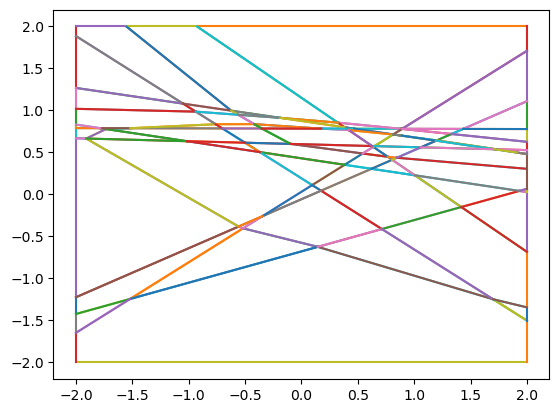

In [9]:
print(len(regions))
for region in regions:
    for simplex in region.convex_hull.simplices:
        plt.plot(region.convex_hull.points[simplex, 0], region.convex_hull.points[simplex, 1])